In [47]:
import logging
import pandas as pd
from sklearn.linear_model import LinearRegression
import wandb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pickle
import os,sys,yaml
import requests

module_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))

if module_path not in sys.path:
    sys.path.append(module_path)
# Now you can import your module
from src.DataOps.feature_engg import feature_engg_class
from src.ModelOps.model_fit import ModelFit
from src.DataOps.feature_engg import feature_engg_class
import numpy as np

In [3]:
#load NASA_API_KEY from .env file
import os
from dotenv import load_dotenv
load_dotenv()
ALPHA_VANTAGE_API_KEY=os.getenv("ALPHA_VANTAGE_API_KEY")

In [33]:
import requests
import json
from tqdm import tqdm


def request_stock_price_hist(symbol, token, sample = False):
    if sample == False:
        q_string = 'https://www.alphavantage.co/query?function=TIME_SERIES_WEEKLY_ADJUSTED&symbol={}&outputsize=full&apikey={}'
    else:
        q_string = 'https://www.alphavantage.co/query?function=TIME_SERIES_WEEKLY_ADJUSTED&symbol={}&apikey={}'

    print("Retrieving stock price data from Alpha Vantage (This may take a while)...")
    r = requests.get(q_string.format(symbol, token))
    print("Data has been successfully downloaded...")
    date = []
    colnames = list(range(0, 6))
    df = pd.DataFrame(columns = colnames)
    print("Sorting the retrieved data into a dataframe...")
    for i in tqdm(r.json()['Weekly Adjusted Time Series'].keys()):
        date.append(i)
        row = pd.DataFrame.from_dict(r.json()['Weekly Adjusted Time Series'][i], orient='index').reset_index().T[1:]
        df = pd.concat([df, row], ignore_index=True)
    df.columns = ["open", "high", "low", "close", "adjusted close", "volume", "dividend amount"]
    df['date'] = date
    df = df.set_index('date')
    return df


In [38]:
data=request_stock_price_hist('IBM', ALPHA_VANTAGE_API_KEY)

Retrieving stock price data from Alpha Vantage (This may take a while)...
Data has been successfully downloaded...
Sorting the retrieved data into a dataframe...


100%|██████████| 1278/1278 [00:01<00:00, 754.44it/s]


In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1278 entries, 2024-05-03 to 1999-11-12
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   open             1278 non-null   object
 1   high             1278 non-null   object
 2   low              1278 non-null   object
 3   close            1278 non-null   object
 4   adjusted close   1278 non-null   object
 5   volume           1278 non-null   object
 6   dividend amount  1278 non-null   object
dtypes: object(7)
memory usage: 79.9+ KB


In [42]:
#convert all columns to numeric
data = data.apply(pd.to_numeric, errors='coerce')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1278 entries, 2024-05-03 to 1999-11-12
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   open             1278 non-null   float64
 1   high             1278 non-null   float64
 2   low              1278 non-null   float64
 3   close            1278 non-null   float64
 4   adjusted close   1278 non-null   float64
 5   volume           1278 non-null   int64  
 6   dividend amount  1278 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 79.9+ KB


In [45]:
#sort the data by date in ascending order
data = data.sort_index(ascending=True)

<Axes: xlabel='date'>

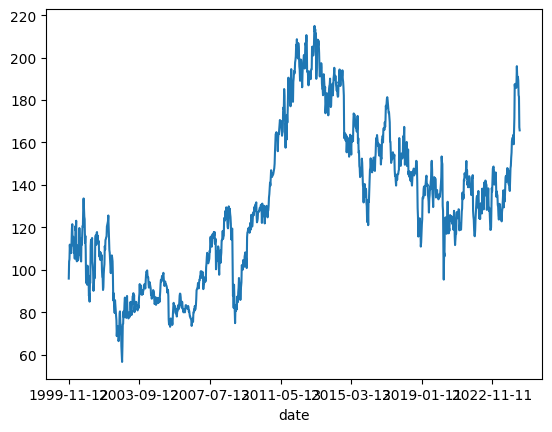

In [46]:
 #plot the close column 
data['close'].plot()

### Linear Regression with Time Series
#### Time-step features
There are two kinds of features unique to time series: time-step features and lag features.

Time-step features are features we can derive directly from the time index. The most basic time-step feature is the time dummy, which counts off time steps in the series from beginning to end.

In [52]:
df_lr=data.copy()
df_lr=df_lr[['close']]
df_lr['Time'] = np.arange(len(df_lr.index))
df_lr.head()

,close,Time
date,,
1999-11-12,95.87,0
1999-11-19,103.94,1
1999-11-26,105.00,2
1999-12-03,111.87,3
1999-12-10,109.00,4


In [53]:
from sklearn.linear_model import LinearRegression

# Training data
X = df_lr.loc[:, ['Time']]  # features
y = df_lr.loc[:, 'close']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

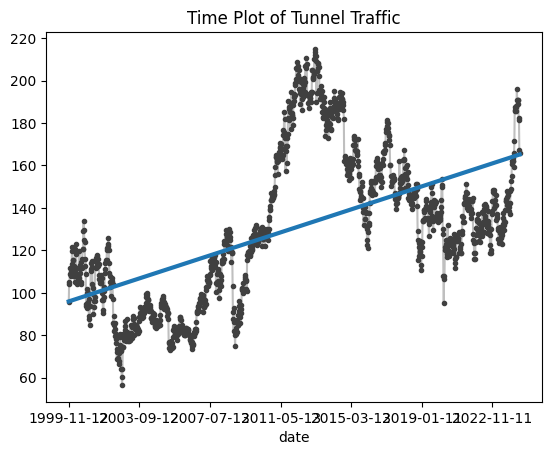

In [51]:
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Tunnel Traffic');

In [54]:
#creating a lag feature
df_lr['close_lag1'] = df_lr['close'].shift(1)
df_lr.head()

,close,Time,close_lag1
date,,,
1999-11-12,95.87,0,NaN
1999-11-19,103.94,1,95.87
1999-11-26,105.00,2,103.94
1999-12-03,111.87,3,105.00
1999-12-10,109.00,4,111.87


When creating lag features, we need to decide what to do with the missing values produced. Filling them in is one option, maybe with 0.0 or "backfilling" with the first known value. Instead, we'll just drop the missing values, making sure to also drop values in the target from corresponding dates

In [57]:
from sklearn.linear_model import LinearRegression

X = df_lr.loc[:, ['close_lag1']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = df_lr.loc[:, 'close']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

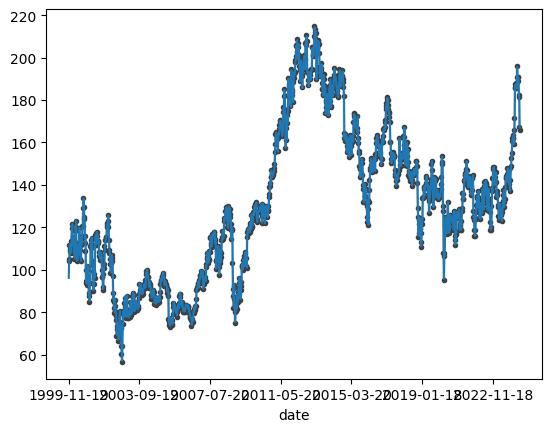

In [58]:
ax = y.plot(**plot_params)
ax = y_pred.plot()

### What is Trend?
The trend component of a time series represents a persistent, long-term change in the mean of the series. The trend is the slowest-moving part of a series, the part representing the largest time scale of importance. In a time series of product sales, an increasing trend might be the effect of a market expansion as more people become aware of the product year by year

To see what kind of trend a time series might have, we can use a moving average plot. To compute a moving average of a time series, we compute the average of the values within a sliding window of some defined width. Each point on the graph represents the average of all the values in the series that fall within the window on either side. The idea is to smooth out any short-term fluctuations in the series so that only long-term changes remain.

In [61]:
df_trend=data.copy()
df_trend=df_trend[['close']]

<Axes: title={'center': 'Stock Price - 365-Day Moving Average'}, xlabel='date'>

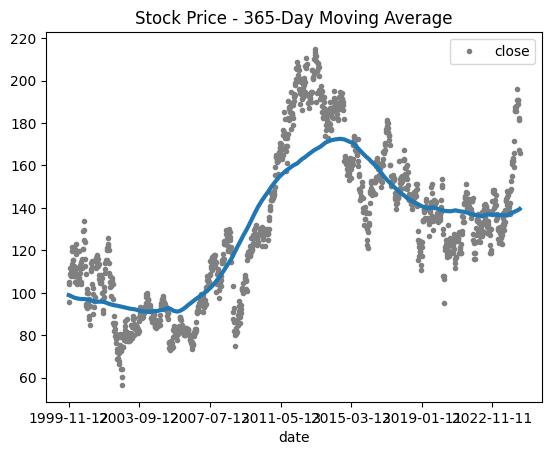

In [63]:
moving_average = df_trend.rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = df_trend.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Stock Price - 365-Day Moving Average", legend=False,
)

In [ ]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=df_trend.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()